# Words and Their Co-occurences

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image

from vdata import Voynich, Folio
a = Voynich()

In [3]:
lines = list(a.data[a.data.words <= 4].text)
words = ' '.join(lines).split()
print(len(lines), 'lines')
print(len(words), 'words')

1493 lines
2895 words


Don't worry, we still have most of them

In [4]:
lines = list(a.data[a.data.words > 4].text)
words = ' '.join(lines).split()
print(len(lines), 'lines')
print(len(words), 'words')

3721 lines
34991 words


In [5]:
lines[:10]

['fachys ykal ar ataiin shol shory cthres y kor sholdy',
 'sory ckhar or y kair chtaiin shar are cthar cthar dan',
 'syaiir sheky or ykaiin shod cthoary cthes daraiin sa',
 'ooiin oteey oteos roloty cthar daiin otaiin or okan',
 'dair y chear cthaiin cphar cfhaiin',
 'odar o y shol cphoy oydar sh s cfhoaiin shodary',
 'yshey shody okchoy otchol chocthy oschy dain chor kos',
 'ydain cphesaiin ol s cphey ytain shoshy cphodales',
 'oksho kshoy otairin oteol okan shodain sckhey daiin',
 'shoy ckhey kodaiin cphy cphodaiils cthey she oldain d']

# Bigram co-occurences

In [30]:
def build_ngram_dict(text, n=3):
    """
    text is an array of whatever you want to find
    """
    trigrams = [text[i:i+n] for i in range(len(text) - n)]
    trigrams = list(set(trigrams))
    t2i = {x:i for i,x in enumerate(trigrams)}
    i2t = {x:i for i,x in t2i.items()}
    return t2i, i2t

In [31]:
text = ' '.join(lines)
text = text

In [48]:
from collections import deque

t2i, i2t = build_ngram_dict(text, n=2)
n = len(t2i.keys())

print('building a {} by {} matrix...'.format(n,n))

# build co_occurence matrix
co_occurences = np.zeros((n,n))

# run through the text
d = deque(maxlen=20)
for i in range(len(text) - 2):
    chars = text[i:i+2]
    if ' ' in chars:
        continue # skips spaces
    for i in d:
        a_int = t2i[chars]
        b_int = t2i[i]
        co_occurences[a_int, b_int] += 1
    
    d.append(chars)
print('done')

building a 324 by 324 matrix...
done


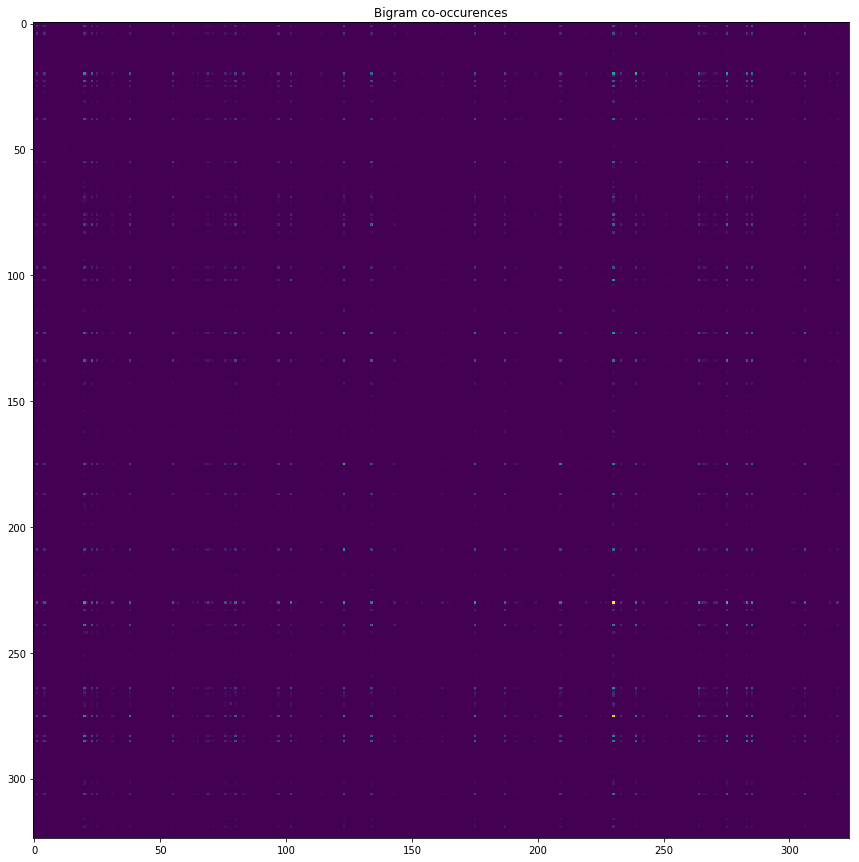

In [137]:
# visualize the result
plt.figure(figsize=(15,15))
plt.title('Bigram co-occurences')
_ = plt.imshow(co_occurences)

We want to filter out all the background and only get the high-frequency co-occurences

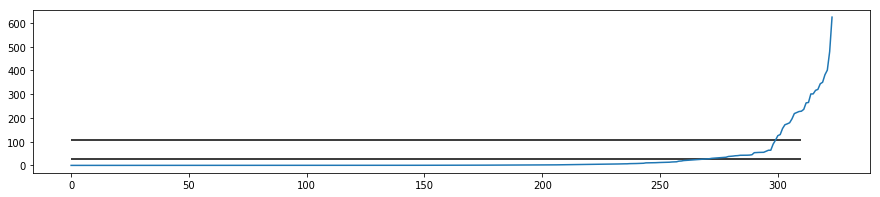

In [138]:
va = np.mean(co_occurences, axis=0)
mean, sd = np.mean(va), np.std(va)

plt.figure(figsize=(15, 3))
plt.plot(sorted(va))
plt.hlines([mean, mean+sd], 0, 310)

[  1   4  20  21  23  25  31  38  55  57  65  68  69  70  71  76  78  80
  83  97 102 104 114 123 134 143 154 162 175 187 191 209 219 225 230 231
 233 239 242 251 264 265 266 267 270 271 275 282 283 285 301 302 306 316
 319]


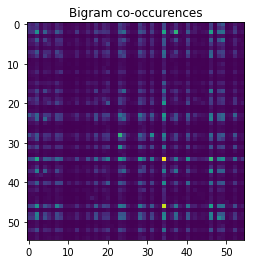

In [139]:
va_good = np.where(va > mean)
indices = va_good[0]
print(indices)

new_stuff = co_occurences[indices, :][:,indices]

# visualize the result
plt.title('Bigram co-occurences')
_ = plt.imshow(new_stuff)

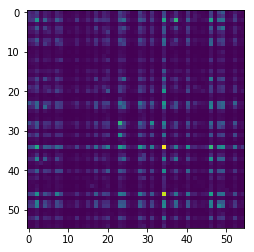

In [142]:
u, s, vh = np.linalg.svd(new_stuff, full_matrices=True)
u.shape, s.shape, vh.shape
plt.imshow(np.matmul(u*s, vh))

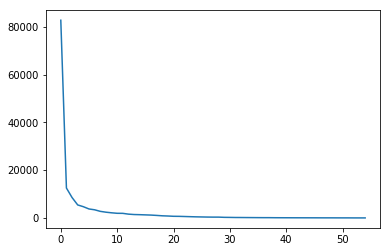

In [143]:
plt.plot(s)

Something that's funny to me is the way that these things are arranged in literal columns. I guess this means that within the 20-window, the counts are picking up on more of a per-word occurence detail than anything else... I wonder what'd happen if I strip the first PC

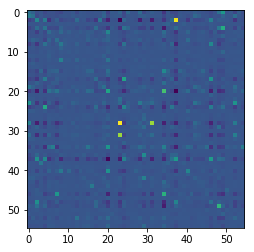

In [145]:
scopy = np.copy(s)

scopy[0] = 0 # 1 PC does well enough at capturing the broad statistics
# plt.figure(figsize=(15,15))
plt.imshow(np.matmul(u*scopy, vh))

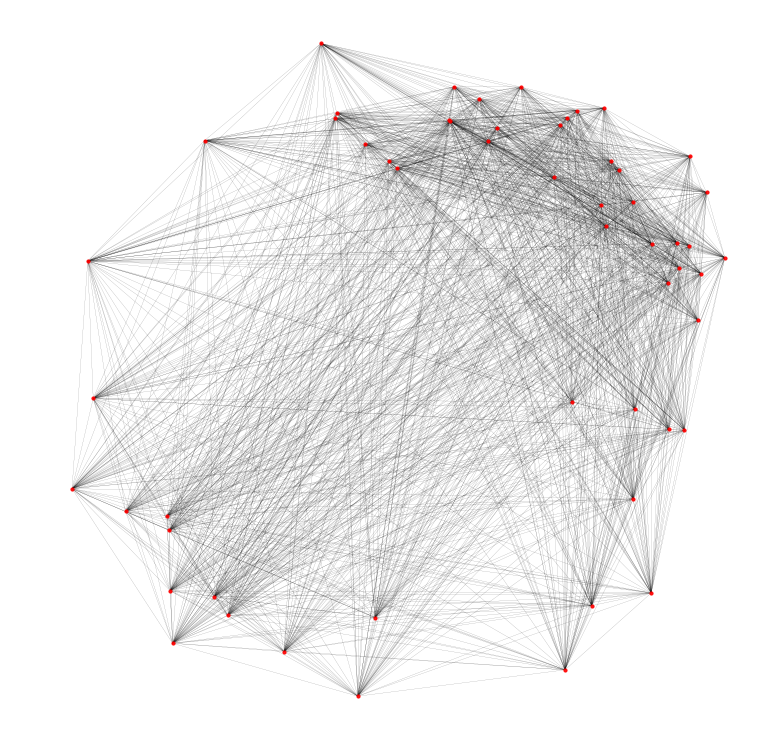

In [168]:
import networkx as nx

# I don't know what this graph means
g = nx.Graph(np.matmul(u*scopy, vh))
# g = nx.Graph(new_stuff)
plt.figure(figsize=(10,10))
nx.draw(g, width=0.1, node_size=10, alpha=0.9)

In [165]:
bgr = [i2t[x] for x in indices]
print(bgr)

['ka', 'al', 'dy', 'ck', 'ke', 'or', 'kc', 'sh', 'eo', 'os', 'ko', 'ra', 'od', 'lo', 'yt', 'hy', 'ct', 'ey', 'hd', 'ar', 'ho', 'ek', 'ir', 'ai', 'ee', 'lk', 'ty', 'to', 'in', 'ot', 'sa', 'ii', 'am', 'es', 'ch', 'hc', 'te', 'ed', 'kh', 'oc', 'ol', 'lc', 'ta', 'ha', 'th', 'pc', 'he', 'do', 'qo', 'ok', 'op', 'ky', 'da', 'yk', 'tc']


What would we expect if some group of letters were vowels and some were consonants? We might write a CFG like this:
* V -> ai, e, o, k
* C -> a, l, dy, n, etc
* loss(VC) = 0, loss(CC) = 0.1, loss(VV) = 0.1 

And then let it generate the best group of vowels and consonants.

# Let's try this thing for words too

In [18]:
def build_ngram_dict_from_list(text, n=3):
    """
    text is an array of whatever you want to find
    """
    trigrams = [' '.join(text[i:i+n]) for i in range(len(text) - n)]
    trigrams = list(set(trigrams))
    t2i = {x:i for i,x in enumerate(trigrams)}
    i2t = {x:i for i,x in t2i.items()}
    return t2i, i2t

In [19]:
from collections import deque

text = ' '.join(lines).split()
t2i, i2t = build_ngram_dict_from_list(text, n=2)
n = len(t2i.keys())

print('building a {} by {} matrix...'.format(n,n))

building a 29912 by 29912 matrix...


In [27]:
'that would be', 29912**2 / 1000/1000, 'megabytes. we can\' do that'

('that would be', 894.7277439999999, "megabytes. we can' do that")

In [25]:
# filter where the words occur more than once

## What does it mean for certain bigrams/letters to be frequently co-located?

* I don't know yet

What is the length of words here?

In [236]:
len(list(udhr.words('English-Latin1')))

1781

In [260]:
from nltk.corpus import europarl_raw
from itertools import islice

finnish = europarl_raw.finnish.words()
for t in nltk.bigrams(islice(finnish, 10)):
    print(t)

('Istuntokauden', 'uudelleenavaaminen')
('uudelleenavaaminen', 'Julistan')
('Julistan', 'perjantaina')
('perjantaina', 'joulukuun')
('joulukuun', '17.')
('17.', 'päivänä')
('päivänä', 'keskeytetyn')
('keskeytetyn', 'Euroopan')
('Euroopan', 'parlamentin')


 dir(europarl_raw)

 'danish',
 'dutch',
 'english',
 'finnish',
 'french',
 'german',
 'greek',
 'italian',
 'portuguese',
 'spanish',

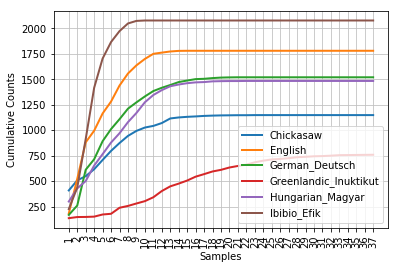

In [231]:
import nltk
# # nltk.download('udhr')
# nltk.download('europarl_raw')

from nltk.corpus import udhr
languages = ['Chickasaw', 'English', 'German_Deutsch',
             'Greenlandic_Inuktikut', 'Hungarian_Magyar', 'Ibibio_Efik']
cfd = nltk.ConditionalFreqDist(
    (lang, len(word))
    for lang in languages
    for word in udhr.words(lang + '-Latin1'))

cfd.plot(cumulative=True)

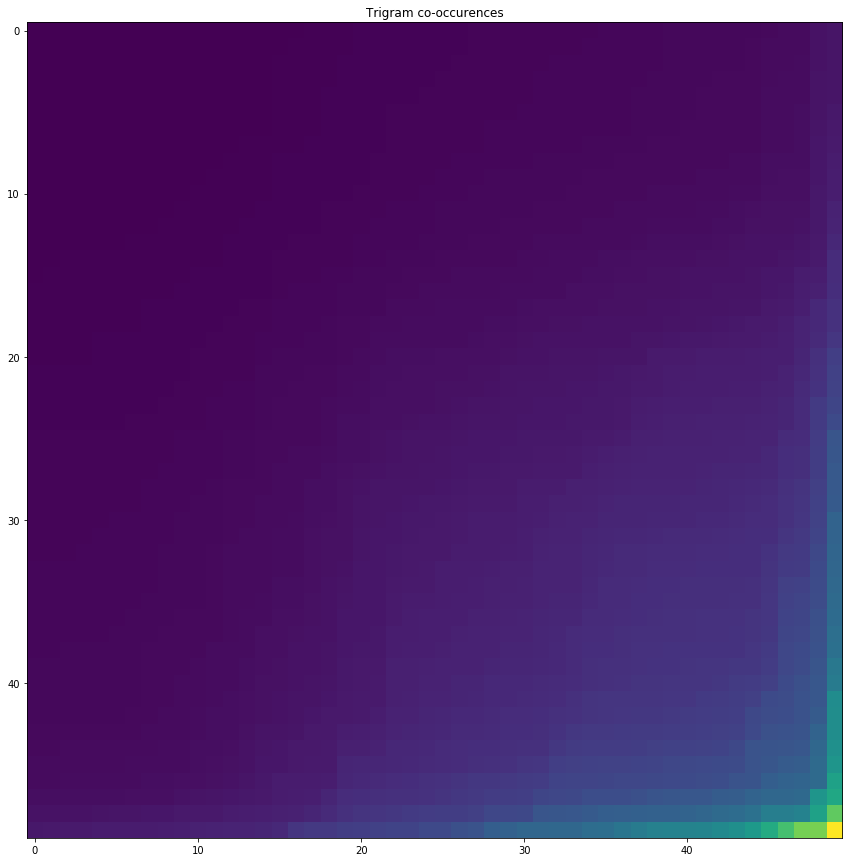

In [213]:
# we could also sort 
co_occurences.sort(0)
co_occurences.sort(1)

# visualize the result
plt.figure(figsize=(15,15))
plt.title('Trigram co-occurences')
_ = plt.imshow(co_occurences[-50:, -50:])

In [94]:
co_occurences[-50:, -50:]

array([[  2.,   2.,   2., ...,  19.,  23.,  31.],
       [  2.,   2.,   2., ...,  19.,  23.,  32.],
       [  2.,   2.,   2., ...,  19.,  23.,  32.],
       ...,
       [ 11.,  11.,  12., ..., 105., 131., 248.],
       [ 14.,  14.,  14., ..., 130., 141., 282.],
       [ 15.,  15.,  16., ..., 153., 251., 294.]])